# Spatial analysis of 10X example Visium dataset

# Introduction

In a [more introductory vignette](https://pmelsted.github.io/voyagerpy/examples/visium_10x.html), we performed basic non-spatial analyses on a mouse olfactory bulb Visium dataset from the 10X website. In this vignette, we perform spatial analyses in histological space as well as in gene expression space.

Here we load the packages used in this vignette:

In [1]:
import sys
import subprocess

def install_packages_colab():
    """Install Python packages using pip."""
    packages = [
        'voyagerpy==0.1.1',
        'gget==0.28.4',
        'watermark==2.4.3',
        'scanpy==1.10.1'
    ]
    # Command construction for pip install
    command = [sys.executable, '-m', 'pip', 'install'] + packages
    try:
        # Execute the command
        subprocess.check_call(command)
        print("Packages installed successfully.")
    except subprocess.CalledProcessError:
        print("Failed to install packages.")
        raise

if 'google.colab' in sys.modules:  # if in google colab
    install_packages_colab()

Note: in Colab, the runtime may need to be restarted after installing the packages with the above cell.

In [2]:
import voyagerpy as vp

# Data handling and plotting
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# File management and downloading
import os
import tarfile
import requests
import pathlib
import json
import gget  # mapping ensembl gene IDs to gene symbols

# Graph/matrix handling
import networkx as nx  # graph generation
from scipy.sparse import csr_matrix, issparse  # matrix handling
import scanpy as sc  # PCA and KNN

# Image handling
from scipy.ndimage import binary_opening, binary_closing, binary_fill_holes
from skimage.measure import label, regionprops
from skimage import color, morphology
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from shapely.affinity import scale
from matplotlib.lines import Line2D
from shapely.geometry import Point
from shapely.predicates import contains
from scipy.stats import gaussian_kde

plt.rcParams['axes.grid'] = False
plt.rcParams['axes.edgecolor'] = 'none'  # Hides the axes border
# plt.rcParams['xtick.color'] = 'none'  # Hides x-axis ticks
# plt.rcParams['ytick.color'] = 'none'  # Hides y-axis ticks

plt.rcParams['figure.dpi'] = 120

# Turn on matplotlib interactive mode so we don't need to explicitly call plt.show()
_ = plt.ion()

In [3]:
root_dir = pathlib.Path(os.getcwd())
data_dir = pathlib.Path(f'{root_dir}/data')
outs_dir = pathlib.Path(f'{root_dir}/outs')

data_dir.mkdir(parents=True, exist_ok=True)
outs_dir.mkdir(parents=True, exist_ok=True)

def download_data(tar_path, url_reads, outs_dir = outs_dir):
    if not tar_path.exists():
        res = requests.get(url_reads)
        with tar_path.open('wb') as f:
            f.write(res.content)

        try:
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=outs_dir)
                print("Extraction completed successfully!")
        except Exception as e:
            print(f"An error occurred: {e}")

Here we download the data from the 10X website. Contents of the outs directory as from Space Ranger is explained in the [introductory vignette](https://pmelsted.github.io/voyagerpy/examples/visium_10x.html).

In [4]:
# Download the unfiltered gene count matrix
tar_path = data_dir / 'visium_ob.tar.gz'
url_reads = "https://cf.10xgenomics.com/samples/spatial-exp/2.0.0/Visium_Mouse_Olfactory_Bulb/Visium_Mouse_Olfactory_Bulb_raw_feature_bc_matrix.tar.gz"
download_data(tar_path, url_reads)

# This is the spatial information
tar_path_spatial = data_dir / 'visium_ob_spatial.tar.gz'
url_reads_spatial = "https://cf.10xgenomics.com/samples/spatial-exp/2.0.0/Visium_Mouse_Olfactory_Bulb/Visium_Mouse_Olfactory_Bulb_spatial.tar.gz"
download_data(tar_path_spatial, url_reads_spatial)

Here we read the data into Python as an Anndata object

In [5]:
adata_image_res = 'hires'

adata = vp.read_10x_visium(
    outs_dir,
    datatype = 'mtx',
    raw = True,
    prefix = None,
    symbol_as_index=False,
    dtype=np.float64,
    res=adata_image_res
)

Here we add QC metrics and plot them.

In [6]:
is_mt = adata.var['symbol'].str.contains('^mt-').values
vp.utils.add_per_cell_qcmetrics(adata, subsets={'mito': is_mt})

Retrieve the locations of visium spots

In [7]:
visium_spots = vp.spatial.get_visium_spots(adata, with_radius=True)

_ = vp.spatial.set_geometry(adata, geom="spot_poly", values=visium_spots)

In [8]:
adata.uns["config"]

{'var_names': 'gene_ids', 'secondary_var_names': 'symbol'}

In [9]:
adata.obsm['geometry']

spot_poly
AAACAACGAATAGTTC-1  POLYGON ((227.561 1552.400, 227.526 1551.678, ...
AAACAAGTATCTCCCA-1  POLYGON ((1211.761 577.400, 1211.726 576.678, ...
AAACAATCTACTAGCA-1  POLYGON ((286.361 1246.400, 286.326 1245.678, ...
AAACACCAATAACTGC-1  POLYGON ((1390.161 1517.200, 1390.126 1516.478...
AAACAGAGCGACTCCT-1  POLYGON ((502.561 668.600, 502.526 667.878, 50...
...                                                               ...
TTGTTTCACATCCAGG-1  POLYGON ((1370.161 1256.600, 1370.126 1255.878...
TTGTTTCATTAGTCTA-1  POLYGON ((1409.761 1392.600, 1409.726 1391.878...
TTGTTTCCATACAACT-1  POLYGON ((1114.161 1426.800, 1114.126 1426.078...
TTGTTTGTATTACACG-1  POLYGON ((1665.761 1267.600, 1665.726 1266.878...
TTGTTTGTGTAAATTC-1  POLYGON ((365.161 1155.800, 365.126 1155.078, ...

[4992 rows x 1 columns]

/workspace/voyagerpy/plotting/plot.py:1486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geom_is_poly = geo.geometry.geom_type[0] == "Polygon"


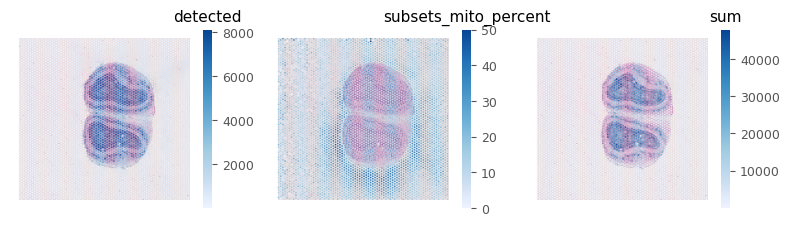

In [10]:
qc_features = ["detected", "subsets_mito_percent", "sum"]
axs = vp.plt.plot_spatial_feature(
    adata,
    qc_features,
    image_kwargs=dict(crop=True),
    ncol = 3,
    subplot_kwargs=dict(figsize=(8,8), dpi=100, layout='tight')
)

## Tissue segmentation

While Space Ranger can automatically detect which spots are in tissue and the Loupe browser can be used to manually annotate which spots are in tissue, it may be interesting to get the tissue outline polygon, so we would know how much each spot overlaps with the tissue and plot the outline. We can perform this boundary detection computationally with scipy.ndimage.

Here we don’t have the full resolution image. We will perform tissue segmentation on the high resolution downsampled image and then scale it to make the coordinates of the tissue boundary match those of the spots.

In [11]:
image_path = f'{outs_dir}/spatial/tissue_hires_image.png'
im = plt.imread(image_path)

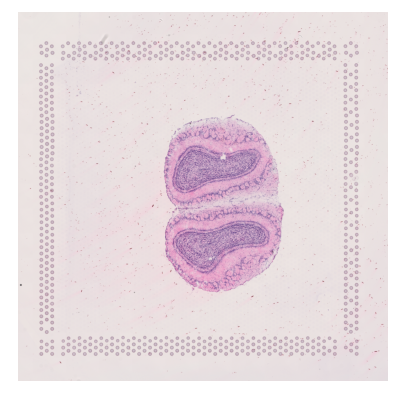

In [12]:
fig, ax = plt.subplots(figsize=(4,4))
_ = vp.plt.imshow(adata, ax = ax, origin = 'upper')

The array of dots framing the tissue seen in this image is the fiducials, used to align the tissue image to the positions of the Visium spots, so gene expression can be matched to spatial locations. The alignment of the fiducials is shown in `aligned_fiducials.jpg`. Space Ranger can automatically detect which spots are in tissue, and these spots are highlighted in `detected_tissue_image.jpg`.

Inside the `scalefactors_json.json` file:

In [13]:
json_path = outs_dir / 'spatial' / 'scalefactors_json.json'

with json_path.open() as file:
    print(json.load(file))

{'tissue_hires_scalef': 0.2, 'tissue_lowres_scalef': 0.06, 'fiducial_diameter_fullres': 118.91545, 'spot_diameter_fullres': 73.61433}


Here we show the RGB channels separately

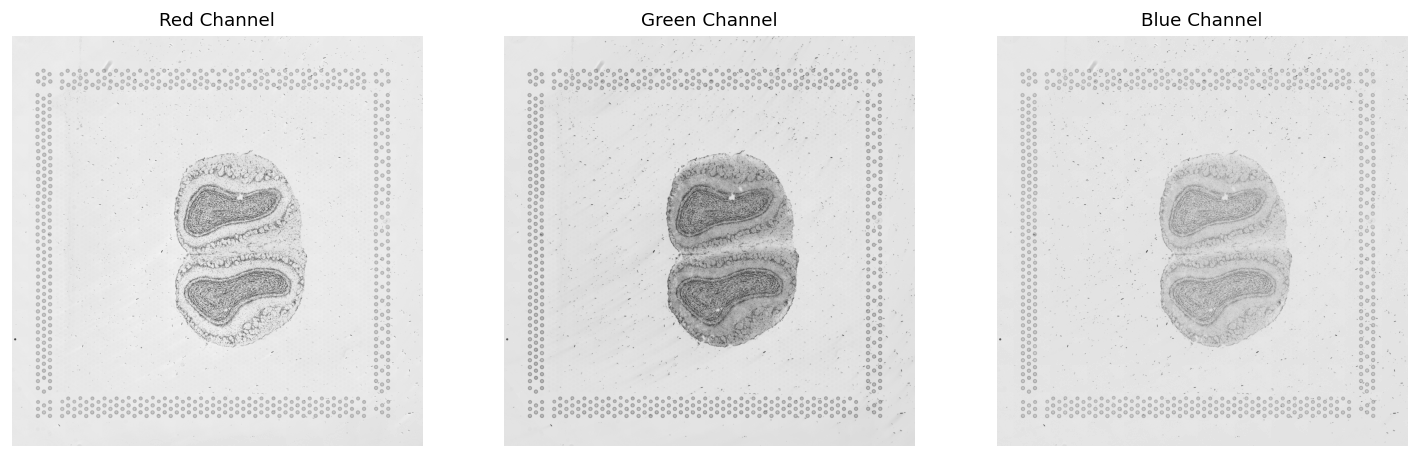

In [14]:
# Split the image into RGB components
r = im[:, :, 0]
g = im[:, :, 1]
b = im[:, :, 2]

r = np.flipud(r)
g = np.flipud(g)
b = np.flipud(b)

# Create a figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display each channel
axs[0].imshow(r, cmap='gray', origin='lower')
axs[0].set_title('Red Channel')
axs[0].axis('off')

axs[1].imshow(g, cmap='gray', origin='lower')
axs[1].set_title('Green Channel')
axs[1].axis('off')

axs[2].imshow(b, cmap='gray', origin='lower')
axs[2].set_title('Blue Channel')
axs[2].axis('off')

plt.show()

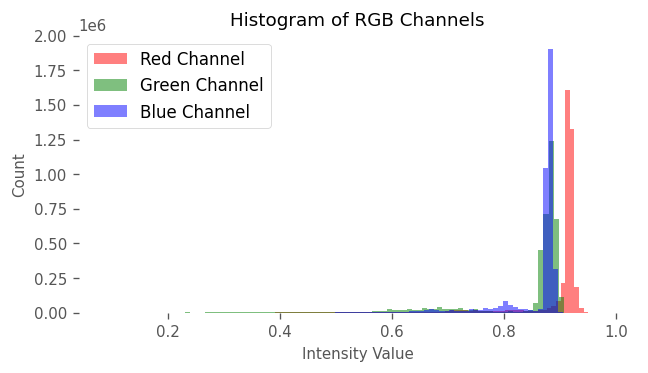

In [15]:
r = im[:, :, 0].flatten()
g = im[:, :, 1].flatten()
b = im[:, :, 2].flatten()

# Create histograms
plt.figure(figsize=(6,3))
plt.hist(r, bins=100, color='red', alpha=0.5, label='Red Channel')
plt.hist(g, bins=100, color='green', alpha=0.5, label='Green Channel')
plt.hist(b, bins=100, color='blue', alpha=0.5, label='Blue Channel')

# Add labels and title
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.title('Histogram of RGB Channels')
plt.legend()

# Show the plot
plt.show()

The tissue can be discerned with thresholding. The tall peak on the right is the background. The much lower peaks from around 0.6 to 0.85 must be the tissue. To capture the faint bluish region, the blue channel is used for thresholding. The threshold here is chosen based on the histogram and experimenting with nearby values.

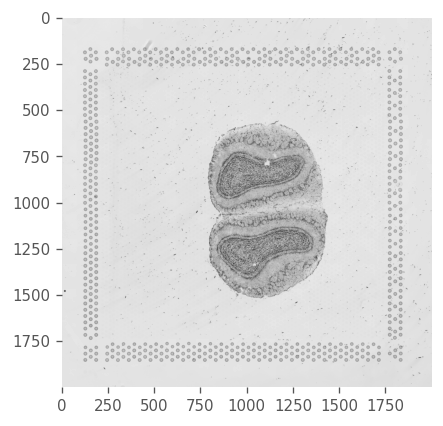

In [16]:
img2 = color.rgb2gray(im)
plt.figure(figsize=(4, 4))
_ = plt.imshow(img2, origin = 'upper', cmap = 'gray')

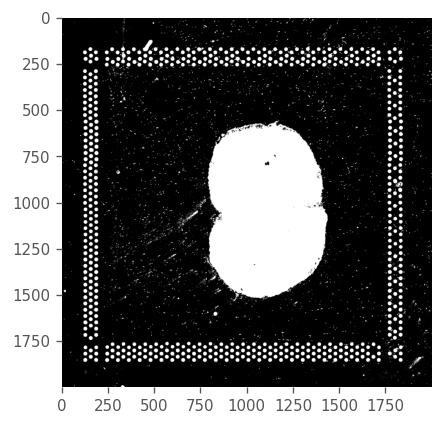

In [17]:
mask = im[:,:,2] < 0.87
plt.figure(figsize=(4, 4))
_ = plt.imshow(mask, origin='upper', cmap = 'gray')

Then we use an opening operation (erosion followed by dilation) to denoise

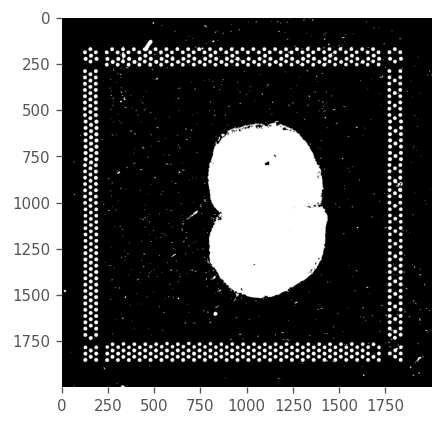

In [18]:
kern = np.ones((3, 3), dtype=np.uint8)

mask_open = binary_opening(mask, structure=kern)

plt.figure(figsize=(4, 4))
_ = plt.imshow(mask_open, origin='upper', cmap = 'gray')

There are some small holes in the tissue, which can be removed by a closing operation (dilation followed by erosion):

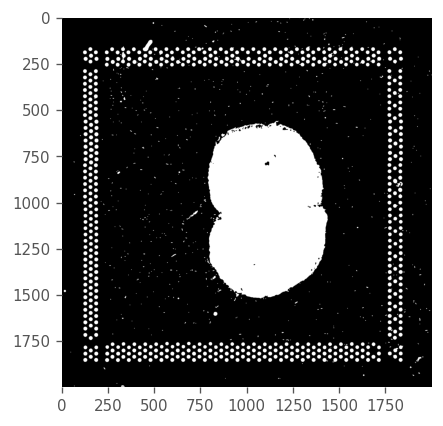

In [19]:
mask_close = binary_closing(mask_open, kern)
plt.figure(figsize=(4, 4))
_ = plt.imshow(mask_close, origin='upper', cmap = 'gray')

There are some larger holes in the tissue mask, which may be real holes or faint regions with few nuclei missed by thresholding. They might not be large enough to affect which Visium spots intersect the tissue.

Now the main piece of tissue is clear. It must be the object with the largest area. However, there are two small pieces that should belong to the tissue at the top left. The debris and fiducials can be removed by setting all pixels in the mask outside the bounding box of the main piece to 0. Here we assign a different value to each contiguous object and find the area among other shape features (e.g. perimeter) of each object.

In [20]:
mask_label = label(mask_close, connectivity=2)
properties = regionprops(mask_label)

def radii_from_centroid(region):
    centroid = np.array(region.centroid)
    coords = np.array(region.coords)
    distances = np.linalg.norm(coords - centroid, axis=1)
    return distances

# Print area and perimeter for each region
for prop in properties[:6]:
    radii = radii_from_centroid(prop)

    print(f"Label: {prop.label}, Area: {prop.area}, Perimeter: {prop.perimeter}, Radius mean: {np.mean(radii)}, Radius std: {np.std(radii)}, Radius min: {np.min(radii)}, Radius max: {np.max(radii)}")

Label: 1, Area: 25.0, Perimeter: 17.621320343559642, Radius mean: 2.1943061647255764, Radius std: 1.018734732620485, Radius min: 0.16492422502469775, Radius max: 4.20323684795417
Label: 2, Area: 15.0, Perimeter: 12.0, Radius mean: 1.5067417439661026, Radius std: 0.6295998599560315, Radius min: 0.0, Radius max: 2.23606797749979
Label: 3, Area: 14.0, Perimeter: 10.82842712474619, Radius mean: 1.4085841751813566, Radius std: 0.4797669597985792, Radius min: 0.7071067811865476, Radius max: 2.1213203435596424
Label: 4, Area: 15.0, Perimeter: 12.0, Radius mean: 1.5067417439661026, Radius std: 0.6295998599560315, Radius min: 0.0, Radius max: 2.23606797749979
Label: 5, Area: 9.0, Perimeter: 8.0, Radius mean: 1.0729838054991534, Radius std: 0.4266603877440328, Radius min: 0.0, Radius max: 1.4142135623730951
Label: 6, Area: 9.0, Perimeter: 8.0, Radius mean: 1.0729838054991534, Radius std: 0.4266603877440328, Radius min: 0.0, Radius max: 1.4142135623730951


In [21]:
max_area = 0
max_label = None
for prop in properties:
    if prop.area > max_area:
        max_area = prop.area
        max_label = prop.label

if max_label is not None:
    inds = np.argwhere(mask_label == max_label)
    print("Coordinates of the region with the max area:")
    print(inds[:6])  # prints first 6 coordinates
else:
    print("No regions found or something went wrong.")

Coordinates of the region with the max area:
[[ 561 1167]
 [ 561 1168]
 [ 561 1169]
 [ 562 1157]
 [ 562 1158]
 [ 562 1159]]


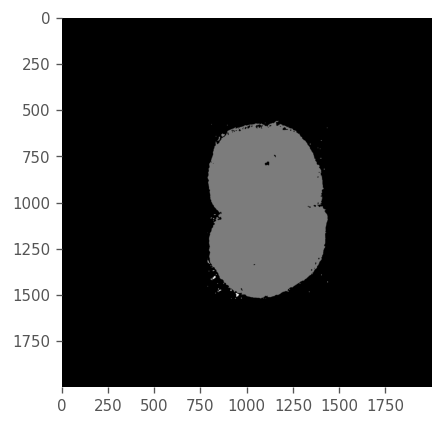

In [22]:
region = next((prop for prop in properties if prop.label == max_label), None)

if region is not None:
    # Extract the bounding box of the region with the max area
    minr, minc, maxr, maxc = region.bbox

    # Compute indices to zero out
    # Rows outside the bounding box
    row_inds = np.concatenate((np.arange(minr), np.arange(maxr + 1, mask_label.shape[0])))
    # Columns outside the bounding box
    col_inds = np.concatenate((np.arange(minc), np.arange(maxc + 1, mask_label.shape[1])))

    # Set these regions in the mask to zero
    mask_label[row_inds, :] = 0
    mask_label[:, col_inds] = 0
else:
    print("Region not found.")

plt.figure(figsize=(4, 4))
_ = plt.imshow(mask_label, origin='upper', cmap = 'gray')

Then remove the small pieces that are debris.

In [23]:
np.unique(mask_label)

array([  0, 419, 423, 427, 428, 436, 448, 456, 459, 467, 471, 481, 485,
       503, 521, 631, 638, 640, 649, 674, 735, 737, 753, 758, 771, 774,
       785, 787, 793, 801, 807, 814, 815, 816, 820, 825, 831, 832, 833,
       836, 838, 841, 842, 854, 855, 856, 858, 859], dtype=int32)

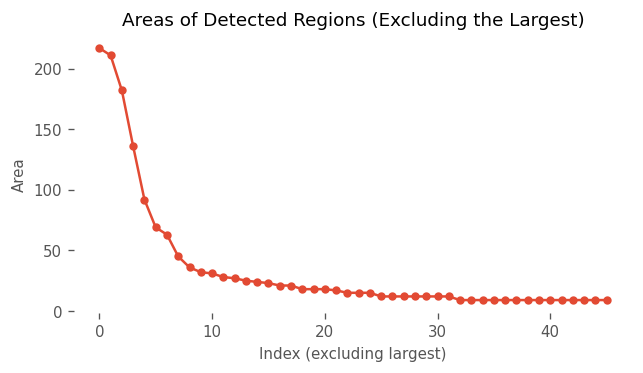

In [24]:
unique_labels = np.unique(mask_label)[1:]
filtered_props = [prop for prop in properties if prop.label in unique_labels]

# Create a DataFrame from the filtered properties
data = {'label': [prop.label for prop in filtered_props], 'area': [prop.area for prop in filtered_props]}

df = pd.DataFrame(data)

# Sort by area
df_sorted = df.sort_values(by='area', ascending=False)

# Plot excluding the largest
plt.figure(figsize=(6,3))
plt.plot(df_sorted['area'].iloc[1:].values, marker='o')  # Line plot with points
plt.xlabel('Index (excluding largest)')
plt.ylabel('Area')
plt.title('Areas of Detected Regions (Excluding the Largest)')
plt.show()

In [25]:
df_sorted[:10]

label      area
0     419  496326.0
5     448     217.0
41    842     211.0
27    793     182.0
7     459     136.0
20    737      92.0
37    833      69.0
43    855      63.0
36    832      45.0
28    801      36.0

Object number 793 is a piece of debris at the bottom left. The other pieces with area over 100 pixels are tissue. Since debris really is small bits of tissue, so the boundary between debris and tissue can be blurry. Here the two are distinguished by morphology on the H&E image and proximity to the main tissue.

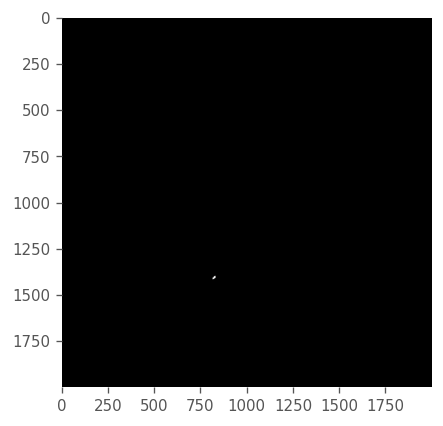

In [26]:
plt.figure(figsize=(4,4))
_ = plt.imshow(mask_label == 793, origin='upper', cmap = 'gray')

Here we remove the debris from the mask

In [27]:
mask_label[mask_label == 793] = 0

for unique_label in unique_labels:
    if int(df_sorted['area'][df_sorted['label'] == unique_label]) < 100:
        mask_label[mask_label == unique_label] = 0

/tmp/ipykernel_50293/2774267249.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(df_sorted['area'][df_sorted['label'] == unique_label]) < 100:


Since most holes in the mask are faint regions of the tissue missed by thresholding, the holes will be filled

In [28]:
mask_label = binary_fill_holes(mask_label)

In [29]:
# Create outlines by subtracting eroded version from the mask
eroded = morphology.erosion(mask_label)
outlines = np.logical_xor(mask_label, eroded)

# Create an RGBA image based on the grayscale image
rgba_img = color.gray2rgba(img2)

# Color map: Modify this part as per the number of labels and required colors
colors = {
    1: (1, 1, 0, 0.3),  # Yellow fill with 30% opacity
    2: (1, 0, 0, 1)     # Red for outlines with full opacity
}

# Apply colors: fill and outlines
for label, color_value in colors.items():
    if label == 1:
        mask = mask_label > 0
        rgba_img[mask] = rgba_img[mask] * (1 - color_value[3]) + np.array(color_value[:3] + (0,)) * color_value[3]
    elif label == 2:
        rgba_img[outlines > 0] = color_value


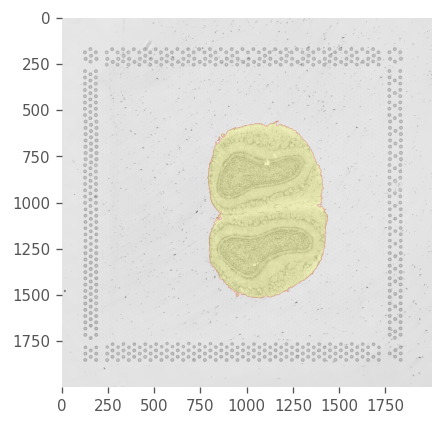

In [30]:
plt.figure(figsize=(4,4))
_ = plt.imshow(rgba_img, origin = 'upper')

This segmentation process took a lot of manual oversight, in choosing the threshold, choosing kernel size and shape in the opening and closing operations, deciding whether to fill the holes, and deciding what is debris and what is tissue.

# Convert tissue mask to polygon

In [31]:
adata.uns["spatial"]["geom"] = {}
adata.uns["spatial"]["geom"]["tissueBoundary_hires"] = vp.spatial.get_tissue_boundary(adata, size = adata_image_res)

/workspace/voyagerpy/spatial/spatial.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_pt = (int(adata.obs["pxl_col_in_fullres"][i] * scl), int(adata.obs["pxl_row_in_fullres"][i] * scl))
/workspace/voyagerpy/spatial/spatial.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs["in_tissue"][i] == 1:
/workspace/voyagerpy/spatial/spatial.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs["in_tissue

The tissue boundary must be scaled between hires image and full image

In [32]:
with json_path.open() as file:
    data = json.load(file)
    lowres_boundary_scale_factor = data['tissue_lowres_scalef']
    hires_boundary_scale_factor = data['tissue_hires_scalef']
    spot_scale_factor = data['spot_diameter_fullres']

adata.uns["spatial"]["geom"]["tissueBoundary"] = scale(adata.uns["spatial"]["geom"]["tissueBoundary_hires"], xfact=1/hires_boundary_scale_factor, yfact = 1/hires_boundary_scale_factor, origin = (0,0))
adata.uns["spatial"]["geom"]["tissueBoundary_lowres"] = scale(adata.uns["spatial"]["geom"]["tissueBoundary"], xfact=lowres_boundary_scale_factor, yfact = lowres_boundary_scale_factor, origin = (0,0))
adata.uns["spatial"]["geom"]["tissueBoundary_hires_exterior"] = adata.uns["spatial"]["geom"]["tissueBoundary_hires"].exterior

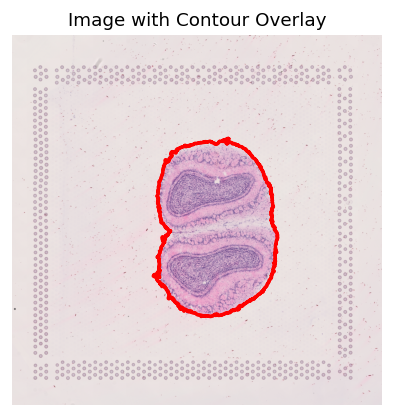

In [33]:
plt.figure(figsize=(4,4))
plt.imshow(im, origin = 'upper')  # Show the image
plt.title('Image with Contour Overlay')
plt.axis('off')  # Hide axes

x, y = adata.uns["spatial"]["geom"]["tissueBoundary_hires"].exterior.xy
plt.plot(x, y, color="red", linewidth=2)  # Plot the polygon with a specified color and line width

plt.show()

/workspace/voyagerpy/plotting/plot.py:1486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geom_is_poly = geo.geometry.geom_type[0] == "Polygon"


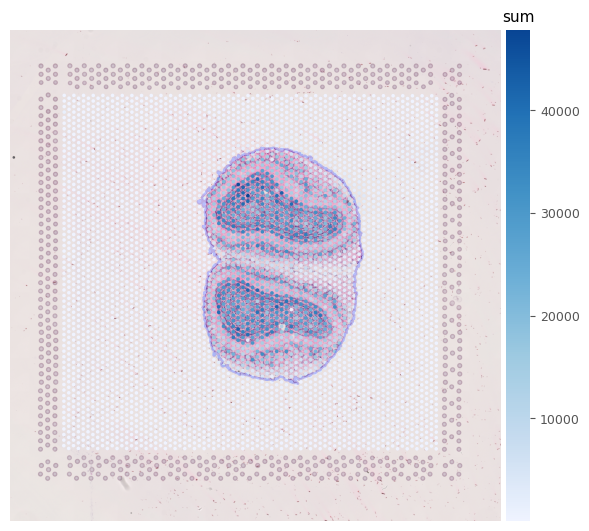

In [34]:
axs = vp.plt.plot_spatial_feature(
    adata,
    "sum",
    image_kwargs=dict(),
    annot_geom = 'tissueBoundary_hires_exterior',
    subplot_kwargs=dict(figsize=(6,6), dpi=100, layout='tight')
)

The mouse olfactory bulb is conventionally plotted horizontally. The image can be transposed in histologial space to make the olfactory bulb horizontal. The tissue boundaries are recomputed on the transposed image.

In [35]:
adata.uns["spatial"]["img"][adata_image_res] = np.swapaxes(adata.uns["spatial"]["img"][adata_image_res], 0, 1)
transposed_im = np.transpose(im, (1, 0, 2))

In [36]:
adata.uns["spatial"]["img"][adata_image_res] = vp.spatial.rotate_img90(adata, k = 2)[adata_image_res]
transposed_im = np.rot90(transposed_im, 2)

In [37]:
adata.uns["spatial"]["geom"]["tissueBoundary_hires"] = vp.spatial.get_tissue_boundary(adata, size = adata_image_res)
adata.uns["spatial"]["geom"]["tissueBoundary"] = scale(adata.uns["spatial"]["geom"]["tissueBoundary_hires"], xfact=1/hires_boundary_scale_factor, yfact = 1/hires_boundary_scale_factor, origin = (0,0))
adata.uns["spatial"]["geom"]["tissueBoundary_lowres"] = scale(adata.uns["spatial"]["geom"]["tissueBoundary"], xfact=lowres_boundary_scale_factor, yfact = lowres_boundary_scale_factor, origin = (0,0))
adata.uns["spatial"]["geom"]["tissueBoundary_hires_exterior"] = adata.uns["spatial"]["geom"]["tissueBoundary_hires"].exterior

/workspace/voyagerpy/spatial/spatial.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_pt = (int(adata.obs["pxl_col_in_fullres"][i] * scl), int(adata.obs["pxl_row_in_fullres"][i] * scl))
/workspace/voyagerpy/spatial/spatial.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs["in_tissue"][i] == 1:
/workspace/voyagerpy/spatial/spatial.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs["in_tissue

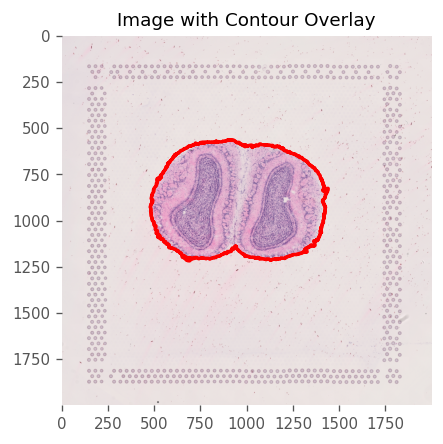

In [38]:
plt.figure(figsize=(4,4))
plt.imshow(transposed_im, origin = 'upper')
plt.title('Image with Contour Overlay')
# plt.axis('off')

x, y = adata.uns["spatial"]["geom"]["tissueBoundary_hires"].exterior.xy
plt.plot(x, y, color="red", linewidth=2)

plt.show()

In [39]:
spatial_coords_df = adata.obs[['pxl_row_in_fullres', 'pxl_col_in_fullres']]
spatial_coords_df

pxl_row_in_fullres  pxl_col_in_fullres
AAACAACGAATAGTTC-1                2237                8899
AAACAAGTATCTCCCA-1                7112                3977
AAACAATCTACTAGCA-1                3767                8605
AAACACCAATAACTGC-1                2413                3085
AAACAGAGCGACTCCT-1                6657                7523
...                                ...                 ...
TTGTTTCACATCCAGG-1                3716                3185
TTGTTTCATTAGTCTA-1                3036                2987
TTGTTTCCATACAACT-1                2865                4466
TTGTTTGTATTACACG-1                3661                1707
TTGTTTGTGTAAATTC-1                4221                8211

[4992 rows x 2 columns]

Then we can use geometric operations to find which spots intersect tissue (intersect with or covered by boundary), which spots are fully covered by tissue (without intersecting), and how much of each spot intersects tissue.

In [40]:
adata.obs['pxl_col_in_fullres_transposed'] = adata.obs.apply(
    lambda row: row['pxl_row_in_fullres'],
    axis=1
)
adata.obs['pxl_row_in_fullres_transposed'] = adata.obs.apply(
    lambda row: row['pxl_col_in_fullres'],
    axis=1
)

adata.obs.rename(columns={
    'pxl_row_in_fullres': 'pxl_row_in_fullres_upright',
    'pxl_col_in_fullres': 'pxl_col_in_fullres_upright',
    'pxl_col_in_fullres_transposed': 'pxl_col_in_fullres',
    'pxl_row_in_fullres_transposed': 'pxl_row_in_fullres'
}, inplace=True)

visium_spots = vp.spatial.get_visium_spots(adata, with_radius=True)
_ = vp.spatial.set_geometry(adata, geom="spot_poly", values=visium_spots)

def check_intersection(row):
    # Create a circle at the given coordinates with the specified radius
    circle = Point(row['pxl_col_in_fullres'], row['pxl_row_in_fullres']).buffer(0.5*spot_scale_factor)

    # Check if the circle intersects any polygon
    found_intersection = circle.intersects(adata.uns["spatial"]["geom"]["tissueBoundary"])

    return found_intersection

def check_contain(row):
    # Create a circle at the given coordinates with the specified radius
    circle = Point(row['pxl_col_in_fullres'], row['pxl_row_in_fullres']).buffer(0.5*spot_scale_factor)

    # Check if the circle intersects any polygon
    found_contain = contains(adata.uns["spatial"]["geom"]["tissueBoundary"], circle)

    return found_contain

adata.obs['intersects_boundary'] = adata.obs.apply(check_intersection, axis=1)
adata.obs['contained_in_boundary'] = adata.obs.apply(check_contain, axis=1)

In [41]:
type(adata.obs['intersects_boundary'])

pandas.core.series.Series

/workspace/voyagerpy/plotting/plot.py:1486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geom_is_poly = geo.geometry.geom_type[0] == "Polygon"


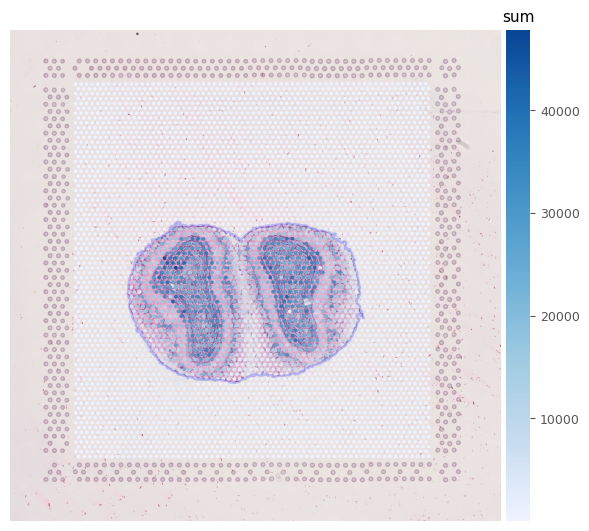

In [42]:
axs = vp.plt.plot_spatial_feature(
    adata,
    "sum",
    image_kwargs=dict(),
    annot_geom = 'tissueBoundary_hires_exterior',
    subplot_kwargs=dict(figsize=(6,6), dpi=100, layout='tight')
)

Discrepancies between Space Ranger’s annotation and the annotation based on tissue segmentation here:

In [43]:
def evaluate_conditions(row):
    if bool(row['in_tissue']) and not bool(row['intersects_boundary']):
        return "Space Ranger"
    elif bool(row['intersects_boundary']) and not bool(row['in_tissue']):
        return "Segmentation"
    else:
        return "Same"
    
adata.obs['diff_sr'] = adata.obs.apply(evaluate_conditions, axis=1)

adata.obs['diff_sr'] = adata.obs['diff_sr'].astype('category')

In [44]:
colors_dict = {'Space Ranger': 'orange', 'Segmentation': 'purple', 'Same': 'gray'}
sorted_color_dict = {key: colors_dict[key] for key in sorted(colors_dict.keys())}
colors_list = list(sorted_color_dict.values())
my_cat_cmap = ListedColormap(colors_list)

/workspace/voyagerpy/plotting/plot.py:1486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geom_is_poly = geo.geometry.geom_type[0] == "Polygon"


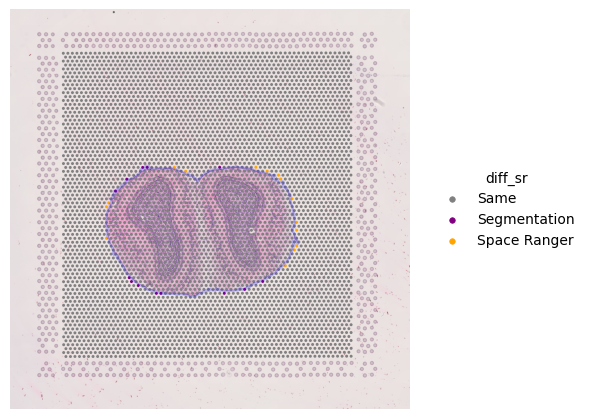

In [45]:
axs = vp.plt.plot_spatial_feature(
    adata,
    "diff_sr",
    annot_geom = 'tissueBoundary_hires_exterior',
    image_kwargs=dict(),
    cat_cmap=my_cat_cmap,
    subplot_kwargs=dict(figsize=(6,6), dpi=100, layout='tight')
)

Spots at the margin can intersect the tissue without being covered by it.

/workspace/voyagerpy/plotting/plot.py:1486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geom_is_poly = geo.geometry.geom_type[0] == "Polygon"


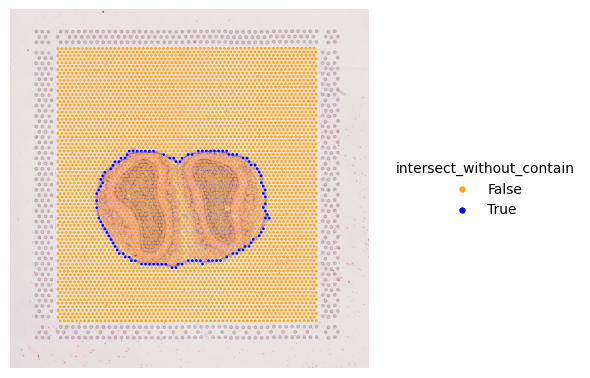

In [46]:
def intersect_without_contain(row):
    if bool(row['intersects_boundary']) and not bool(row['contained_in_boundary']):
        return True
    else:
        return False
    
adata.obs['intersect_without_contain'] = adata.obs.apply(intersect_without_contain, axis=1)

adata.obs['intersect_without_contain'] = adata.obs['intersect_without_contain'].astype('category')

colors_dict = {'True': 'blue', 'False': 'orange'}
sorted_color_dict = {key: colors_dict[key] for key in sorted(colors_dict.keys())}
colors_list = list(sorted_color_dict.values())
my_cat_cmap = ListedColormap(colors_list)

axs = vp.plt.plot_spatial_feature(
    adata,
    "intersect_without_contain",
    annot_geom = 'tissueBoundary_hires_exterior',
    image_kwargs=dict(),
    cat_cmap=my_cat_cmap,
    subplot_kwargs=dict(figsize=(6,6), dpi=100, layout='tight')
)

We can also get the geometries of the intersections between the tissue and the Visium spots, and then calculate what percentage of each spot is in tissue. However, this percentage may not be very useful if the tissue segmentation is subject to error. This percentage may be more useful for pathologist annotated histological regions or objects such as nuclei and myofibers.

In [47]:
def check_fraction_visium_spot_in_tissue(row):
    # Create a circle at the given coordinates with the specified radius
    circle = Point(row['pxl_col_in_fullres'], row['pxl_row_in_fullres']).buffer(0.5*spot_scale_factor)

    # Check if the circle intersects any polygon
    intersection = circle.intersection(adata.uns["spatial"]["geom"]["tissueBoundary"])

    fraction_in_tissue = intersection.area / circle.area

    return fraction_in_tissue

adata.obs['fraction_in_tissue'] = adata.obs.apply(check_fraction_visium_spot_in_tissue, axis=1)

/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


For spots that intersect tissue, does total counts relate to percentage of the spot in tissue?

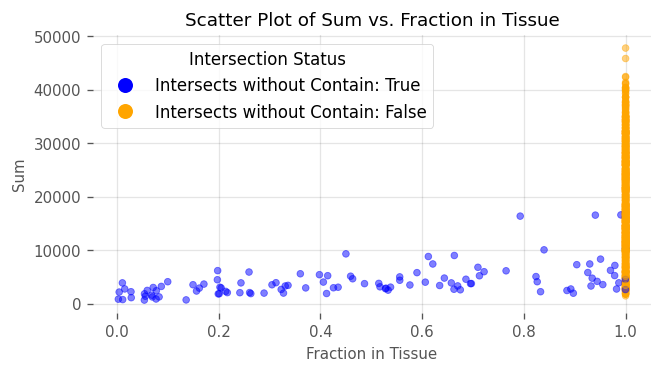

In [48]:
# Create the scatter plot
adata_list = adata.obs[adata.obs['fraction_in_tissue'] > 0]
color_values = adata_list['intersect_without_contain'].astype(str).map({'True': 'blue', 'False': 'orange'})

plt.figure(figsize=(6,3))
plt.scatter(adata_list['fraction_in_tissue'], adata_list['sum'], c=color_values, alpha=0.5)  # alpha for transparency

# Adding labels and title
plt.xlabel('Fraction in Tissue')
plt.ylabel('Sum')
plt.title('Scatter Plot of Sum vs. Fraction in Tissue')

# Show grid
plt.grid(True)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Intersects without Contain: True'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Intersects without Contain: False')
]
plt.legend(handles=legend_elements, title="Intersection Status")

# Display the plot
plt.show()

Spots that are not fully covered by tissue have lower total UMI counts, which can be due to both that they are not fully in tissue and the cell types with lower total counts in the histological region near the edge, as some spots fully covered by tissue also have low UMI counts.

# Spatial autocorrelation of QC metrics

In [49]:
adata_raw = adata.copy()

In [50]:
mask = adata.obs['fraction_in_tissue'] > 0

# Subset the AnnData object using the mask
adata = adata[mask].copy()

visium_spots = vp.spatial.get_visium_spots(adata, with_radius=True)
_ = vp.spatial.set_geometry(adata, geom="spot_poly", values=visium_spots)

In [51]:
nn_graph = 'visium_graph'
nn_graph_object = vp.spatial.find_visium_graph(
    adata,
    subset=None,
    geom=None,
    graph_key=None,
    inplace=False,  # This is important as we don't want to modify the original graph
)

sparse_matrix = csr_matrix(nx.to_scipy_sparse_array(nn_graph_object, nodelist=sorted(nn_graph_object.nodes())))

adata.obsp[nn_graph] = sparse_matrix

AnnData object with n_obs × n_vars = 1183 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres_upright', 'pxl_col_in_fullres_upright', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'intersects_boundary', 'contained_in_boundary', 'diff_sr', 'intersect_without_contain', 'fraction_in_tissue'
    var: 'symbol', 'feature_types'
    uns: 'config', 'spatial', 'metadata'
    obsm: 'geometry'
    obsp: 'visium_graph'

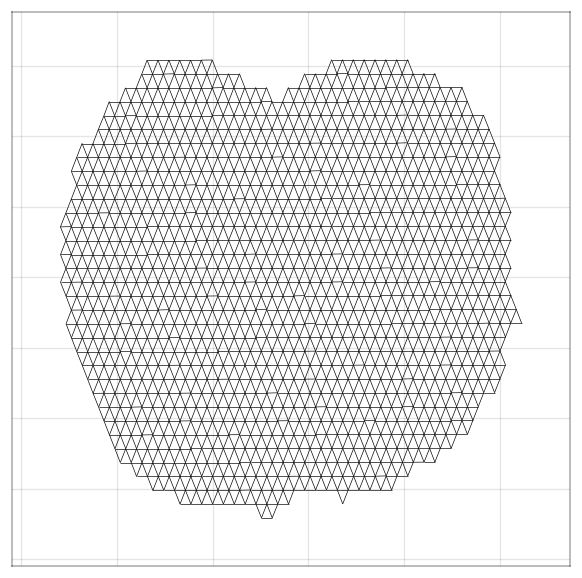

In [69]:
visium_graph = vp.plotting.draw_graph(adata, nn_graph)
vp.spatial.set_default_graph(adata, nn_graph)
vp.spatial.to_spatial_weights(adata, graph_name=nn_graph)

In [70]:
vp.spatial.moran(adata, feature = qc_features, graph_name = nn_graph, permutations = 100)
adata.uns['spatial']['moran'][nn_graph].loc[qc_features, ["I"]]

I
detected              0.739107
subsets_mito_percent  0.640230
sum                   0.729926

In [71]:
adata.uns['spatial']['moran'][nn_graph]

I        EI
detected              0.739107 -0.000846
subsets_mito_percent  0.640230 -0.000846
sum                   0.729926 -0.000846

In [56]:
qc_features

['detected', 'subsets_mito_percent', 'sum']

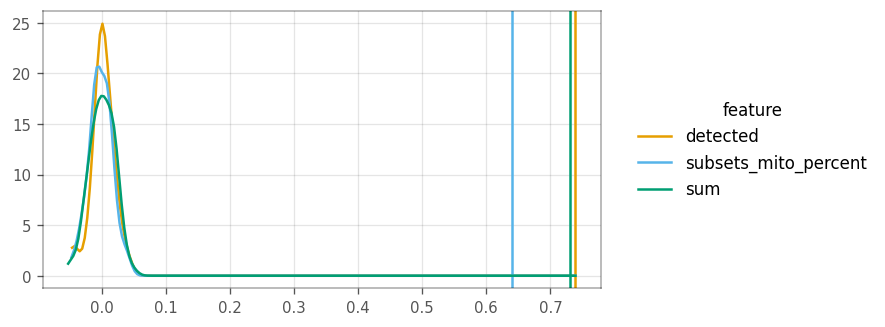

In [72]:
_ = vp.plotting.plot_moran_mc(adata, qc_features, nn_graph, figsize=(6,3))

In [ ]:
vp.spatial.compute_higher_order_neighbors(adata, order=8)
vp.spatial.compute_correlogram(adata, qc_features, order=8)

1         2         3         4         5  \
detected              0.729625   0.58662  0.481802  0.388438  0.298451   
subsets_mito_percent  0.641438  0.418581  0.271027  0.153295  0.069517   
sum                   0.724057  0.579144  0.475263  0.378882  0.282716   

                             6         7         8  
detected              0.215615  0.140907   0.07896  
subsets_mito_percent  0.011905 -0.012297 -0.026774  
sum                   0.197966  0.119662  0.060765

In [ ]:
adata.uns["spatial"]["moran"]["correlogram"][nn_graph]

1         2         3         4         5  \
detected              0.729625   0.58662  0.481802  0.388438  0.298451   
subsets_mito_percent  0.641438  0.418581  0.271027  0.153295  0.069517   
sum                   0.724057  0.579144  0.475263  0.378882  0.282716   

                             6         7         8  
detected              0.215615  0.140907   0.07896  
subsets_mito_percent  0.011905 -0.012297 -0.026774  
sum                   0.197966  0.119662  0.060765

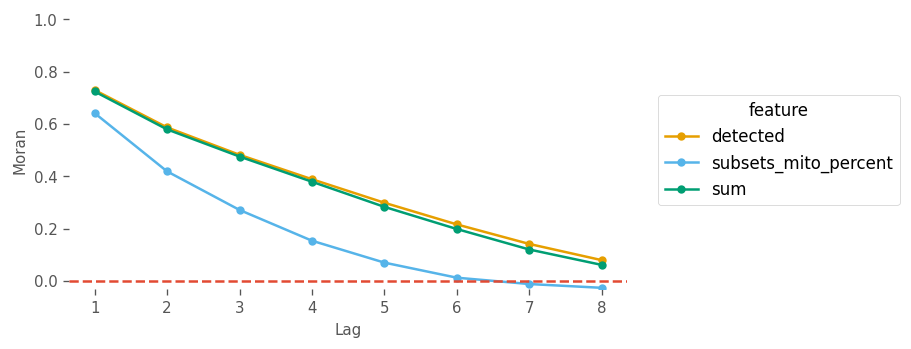

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
_ = vp.plt.plot_correlogram(adata, graph_name = nn_graph, features=qc_features, show_symbol=False, ax=ax)

In [ ]:
_ = vp.spatial.local_moran(adata, feature = qc_features)

/workspace/voyagerpy/plotting/plot.py:1486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geom_is_poly = geo.geometry.geom_type[0] == "Polygon"


array([[<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

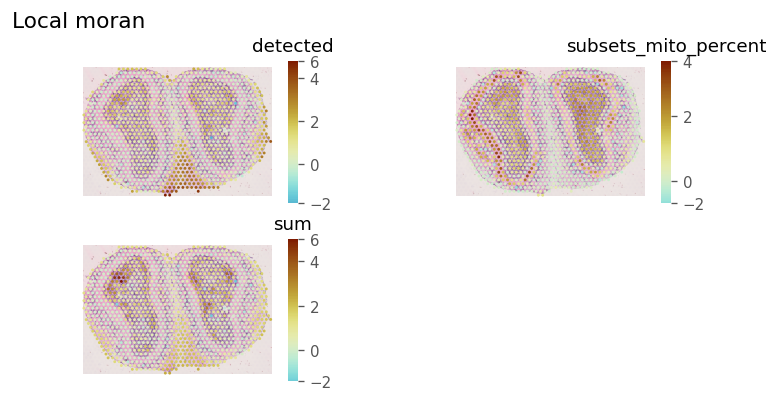

In [ ]:
vp.plotting.plot_local_result(adata, 'local_moran', qc_features, divergent = True, image_kwargs = dict(crop=True), figsize=(6,3))

In [ ]:
_ = vp.spatial.losh(adata, feature = qc_features)

/workspace/voyagerpy/plotting/plot.py:1486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  geom_is_poly = geo.geometry.geom_type[0] == "Polygon"


array([[<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

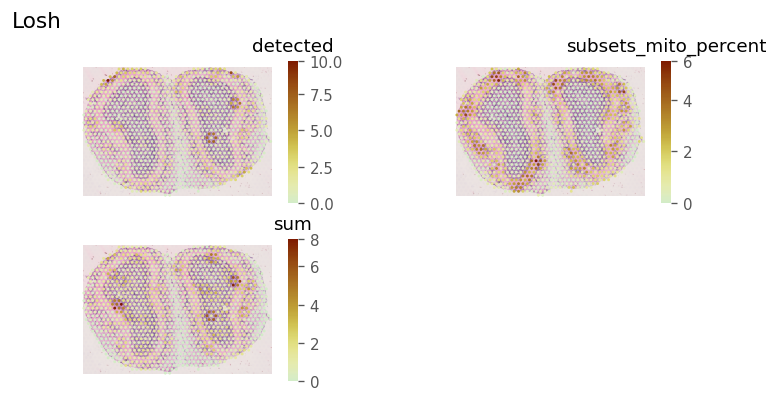

In [ ]:
vp.plotting.plot_local_result(adata, 'losh', qc_features, divergent = True, image_kwargs = dict(crop=True), figsize=(6,3))

array([[<AxesSubplot: xlabel='subsets_mito_percent', ylabel='Spatially lagged subsets_mito_percent'>]],
      dtype=object)

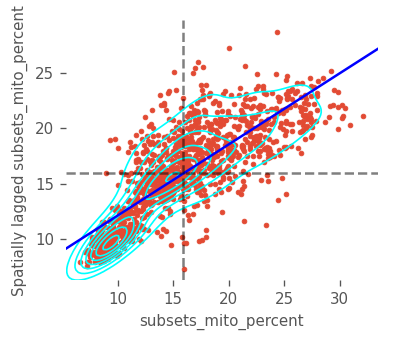

In [ ]:
vp.plotting.moran_plot(adata, feature = 'subsets_mito_percent', graph_name = 'visium_graph', figsize=(3,3))

# Spatial autocorrelation of gene expression
Normalize data and find highly variable genes

In [ ]:
adata.layers['counts'] = adata.X.copy()
vp.utils.log_norm_counts(adata, inplace=True)
adata.layers['logcounts'] = adata.X.copy()

In [ ]:
_ = vp.spatial.set_geometry(adata, geom="spot_poly", values=visium_spots)

In [ ]:
gene_var = vp.utils.model_gene_var(adata.layers['logcounts'], gene_names=adata.var_names)
hvgs = vp.utils.get_top_hvgs(gene_var)
adata.var['highly_variable'] = False
adata.var.loc[hvgs, 'highly_variable'] = True

Find Moran’s I for all highly variable genes:

In [ ]:
vp.spatial.moran(adata, feature=hvgs, dim='var', graph_name=nn_graph)
hvgs_moransI = adata.uns['spatial']['moran'][nn_graph].loc[hvgs, 'I']
adata.var.loc[hvgs, "moran"] = hvgs_moransI

In [ ]:
adata.var.loc[hvgs, ["symbol", "moran"]].sort_values(by='moran')

symbol     moran
ENSMUSG00000020190    Mknk2 -0.060115
ENSMUSG00000027852     Nras -0.050738
ENSMUSG00000041426    Hibch -0.050699
ENSMUSG00000048277   Syngr2 -0.047009
ENSMUSG00000026126   Ptpn18 -0.042040
...                     ...       ...
ENSMUSG00000098178  Gm42418  0.737649
ENSMUSG00000025739    Gng13  0.740344
ENSMUSG00000002985     Apoe  0.800432
ENSMUSG00000019874    Fabp7  0.814784
ENSMUSG00000001023   S100a5  0.842306

[2000 rows x 2 columns]

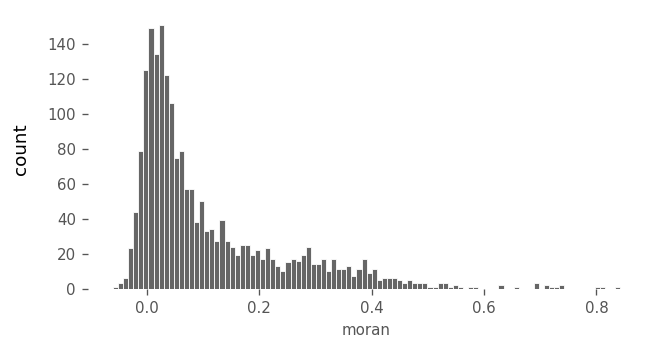

In [ ]:
_ = vp.plt.plot_features_histogram(
    adata,
    "moran",
    bins=100,
    log=False,
    histtype="bar" ,
    show_symbol=True,
    figsize = (6,3)
)

The vast majority of genes have positive Moran’s I. Here we’ll find the genes with the highest Moran’s I:

In [ ]:
top_moran = adata.var[adata.var['highly_variable']]['moran'] \
                    .dropna() \
                    .sort_values(ascending=False) \
                    .head(9) \
                    .index.tolist()

We can use the gget info module from the gget package to get additional information on these genes, such as their descriptions, synonyms, transcripts and more from a collection of reference databases including Ensembl, UniProt and NCBI Here, we are showing their gene descriptions from NCBI:

In [ ]:
for ensembl_id in top_moran:
    # print(ensembl_id)
    try:
        print(f"{ensembl_id}: {gget.info(ensembl_id)['primary_gene_name'].iloc[0]}")
    except:
        print(f"{ensembl_id}: No gene name found")

ENSMUSG00000001023: S100a5
ENSMUSG00000019874: Fabp7
ENSMUSG00000002985: Apoe
ENSMUSG00000025739: Gng13


Thu Jun 13 21:42:12 2024 WARNING ID 'ENSMUSG00000098178' not found. Please double-check spelling/arguments and try again.


ENSMUSG00000098178: No gene name found
ENSMUSG00000015090: Ptgds
ENSMUSG00000090223: Pcp4
ENSMUSG00000064354: Mtco2
ENSMUSG00000064363: No gene name found


Plot the genes with the highest Moran’s I:

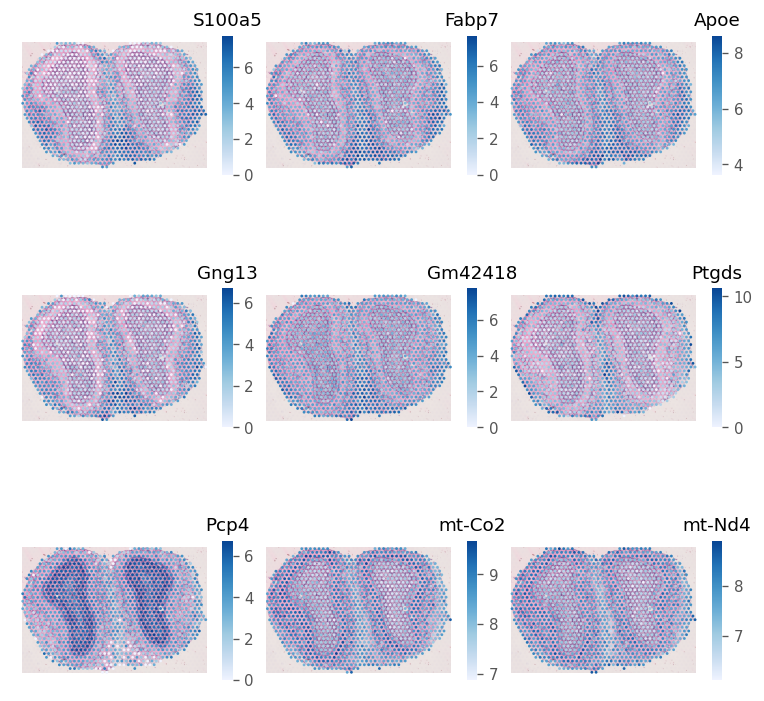

In [ ]:
_ = vp.plt.plot_spatial_feature(
    adata,
    top_moran[:9],
    layer = 'logcounts',
    ncol = 3,
    subplot_kwargs=dict(
        figsize=(6,6),
        layout='constrained',
    ),
    image_kwargs=dict(crop=True)
)

Here global Moran’s I seems to be more about tissue structure.

Some genes have negative Moran’s I that might not be statistically significant:

In [ ]:
neg_moran = adata.var[adata.var['highly_variable']]['moran'] \
                    .dropna() \
                    .sort_values(ascending=True) \
                    .head(9) \
                    .index.tolist()

for ensembl_id in neg_moran:
    # print(ensembl_id)
    try:
        print(f"{ensembl_id}: {gget.info(ensembl_id)['primary_gene_name'].iloc[0]}")
    except:
        print(f"{ensembl_id}: No gene name found")

ENSMUSG00000020190: Mknk2


Tue May 14 21:34:37 2024 WARNING No reviewed UniProt results were found for ID ENSMUSG00000027852. Returning all unreviewed results.


ENSMUSG00000027852: Nras
ENSMUSG00000041426: Hibch
ENSMUSG00000048277: Syngr2
ENSMUSG00000026126: Ptpn18
ENSMUSG00000032228: Tcf12
ENSMUSG00000031431: Tsc22d3
ENSMUSG00000025241: Fyco1
ENSMUSG00000038780: Smurf1


In [ ]:
_ = vp.plt.plot_spatial_feature(
    adata,
    neg_moran[:9],
    layer = 'logcounts',
    ncol = 3,
    subplot_kwargs=dict(
        figsize=(6,6),
        layout='constrained',
    ),
    image_kwargs=dict(crop=True)
)

In [ ]:
vp.spatial.moran(adata, feature = neg_moran, graph_name = nn_graph, dim = 'var', permutations = 200)

In [ ]:
_ = vp.plotting.plot_moran_mc(adata, neg_moran, nn_graph, figsize=(6,3))

In [ ]:
for gene in neg_moran:
    true_moran = adata.uns['spatial']['moran']['visium_graph'].loc[gene, "I"]
    simulated_moran = adata.uns['spatial']['moran_mc']['visium_graph'][gene].iloc[0]['p_sim']
    print(f"{gene} True Moran I: {true_moran}; Simulated Moran I: {simulated_moran}")

ENSMUSG00000020190 True Moran I: -0.06011508802462363; Simulated Moran I: 0.004975124378109453
ENSMUSG00000027852 True Moran I: -0.05073830185049753; Simulated Moran I: 0.014925373134328358
ENSMUSG00000041426 True Moran I: -0.050698982908656744; Simulated Moran I: 0.004975124378109453
ENSMUSG00000048277 True Moran I: -0.04700897387659165; Simulated Moran I: 0.004975124378109453
ENSMUSG00000026126 True Moran I: -0.04204019574974794; Simulated Moran I: 0.009950248756218905
ENSMUSG00000032228 True Moran I: -0.0413075897191022; Simulated Moran I: 0.004975124378109453
ENSMUSG00000031431 True Moran I: -0.03967348493324128; Simulated Moran I: 0.009950248756218905
ENSMUSG00000025241 True Moran I: -0.03847416679733304; Simulated Moran I: 0.009950248756218905
ENSMUSG00000038780 True Moran I: -0.0350438861283254; Simulated Moran I: 0.04477611940298507


As there are 2000 highly variable genes and 2000 tests, these would no longer be significant after correcting for multiple testing.

Does global Moran’s I relate to gene expression level?

In [ ]:
raw_counts = adata.layers['counts']

if issparse(raw_counts):
    # For sparse matrices, compute the mean across the rows (genes)
    mean_expression_across_spots = np.array(raw_counts.mean(axis=0)).flatten()  # mean along columns
else:
    # For dense matrices, you can directly use numpy's mean function
    mean_expression_across_spots = np.mean(raw_counts, axis=0)  # mean along columns

adata.var['mean_expression_across_spots'] = mean_expression_across_spots

In [ ]:
x=adata.var.loc[adata.var['highly_variable'], 'mean_expression_across_spots']
y=adata.var['moran']

plot_data = pd.DataFrame({
    'mean_expression_across_spots': x,
    'moran': y
}).dropna()

xy = np.vstack([plot_data.mean_expression_across_spots, plot_data.moran])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so the densest points are plotted last
plot_data['density'] = z
plot_data = plot_data.sort_values(by='density')

blues_cmap = plt.cm.get_cmap('Blues7')

# Shift the starting point of the colormap
start_point = 0.25
shifted_blues_cmap = LinearSegmentedColormap.from_list(
    'shifted_blues', blues_cmap(np.linspace(start_point, 1, 256)))

plt.figure(figsize=(4,4))
scatterplot = plt.scatter('mean_expression_across_spots', 'moran', data=plot_data, c=plot_data['density'], cmap=shifted_blues_cmap, s=10)
plt.colorbar(scatterplot, label='Density')
plt.xlabel('Mean Expression Across Spots')
plt.xscale('log')
plt.ylabel('Moran’s I')
plt.title('Scatter Plot with Density Dependent Coloring')

plt.show()

Genes that are more highly expressed overall tend to have higher Moran’s I.

# Apply spatial analysis methods to gene expression space

Spatial statistics that require a spatial neighborhood graph can also be applied to the k nearest neighbor graph not in histological space but in gene expression space. This is done in more depth in [this vignette](https://pmelsted.github.io/voyagerpy/examples/nonspatial.html).

In [ ]:
adata.X = vp.utils.scale(adata.X, center=True)

sc.tl.pca(adata, use_highly_variable=True, n_comps=30, random_state=1337)
adata.X = adata.layers['logcounts'].copy()

In [ ]:
sc.pp.neighbors(
    adata,
    n_pcs=10,
    use_rep='X_pca',
    knn=True,
    n_neighbors=10,
    key_added='knn'
)

/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/umap/distances.py:1086: 

In [ ]:
dist = adata.obsp['knn_distances'].copy()
dist.data = 1 / dist.data

# row normalize the matrix, this makes the matrix dense.
dist /= dist.sum(axis=1)

# convert dist back to sparse matrix
adata.obsp["knn_weights"] = csr_matrix(dist)

del dist

knn_graph = "knn_weights"

adata.obsp["knn_connectivities"] = (adata.obsp[knn_graph] > 0).astype(int)
vp.spatial.set_default_graph(adata, knn_graph)
vp.spatial.to_spatial_weights(adata, graph_name=knn_graph)

AnnData object with n_obs × n_vars = 1183 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres_upright', 'pxl_col_in_fullres_upright', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'intersects_boundary', 'contained_in_boundary', 'diff_sr', 'intersect_without_contain', 'fraction_in_tissue'
    var: 'symbol', 'feature_types', 'highly_variable', 'moran', 'mean_expression_across_spots'
    uns: 'config', 'spatial', 'metadata', 'pca', 'knn'
    obsm: 'geometry', 'local_moran', 'losh', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'visium_graph', 'knn_distances', 'knn_connectivities', 'knn_weights'

In [ ]:
morans = vp.spatial.moran(adata, hvgs, dim = 'var', graph_name=knn_graph)

These are the genes that tend to be more similar to their neighbors in the 10 nearest neighbor graph in PCA space for gene expression rather than in histological space:

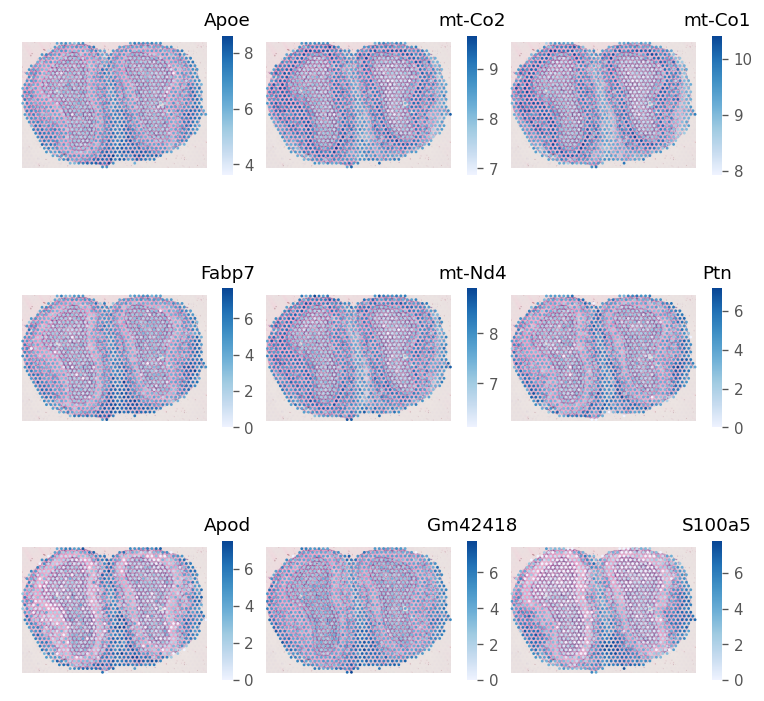

In [ ]:
knn_moran_df = pd.DataFrame(adata.uns['spatial']['moran'][knn_graph])
adata.var['moran_knn'] = adata.var.index.map(knn_moran_df['I'])

top_moran2 = adata.var[adata.var['highly_variable']]['moran_knn'] \
                    .dropna() \
                    .sort_values(ascending=False) \
                    .head(9) \
                    .index.tolist()

_ = vp.plt.plot_spatial_feature(
    adata,
    top_moran2[:9],
    layer = 'logcounts',
    ncol = 3,
    subplot_kwargs=dict(
        figsize=(6,6),
        layout='constrained',
    ),
    image_kwargs=dict(crop=True)
)

Although this Moran’s I was not computed in histological space, these genes with the highest Moran’s I in PCA space also show spatial structure, as different cell types reside in different spatial regions.

# Session info

In [ ]:
%load_ext watermark
%watermark -v -m --iversions
# %watermark -v -m --iversions -p package1,package2,etc

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.18.1

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.3.13-linuxkit
Machine     : aarch64
Processor   : 
CPU cores   : 7
Architecture: 64bit

json      : 2.0.9
voyagerpy : 0.1.1
requests  : 2.31.0
matplotlib: 3.6.3
tarfile   : 0.9.0
gget      : 0.28.4
scanpy    : 1.9.3
sys       : 3.9.18 (main, Oct 12 2023, 02:17:36) 
[GCC 12.2.0]
networkx  : 3.1
skimage   : 0.22.0
pandas    : 1.5.3
numpy     : 1.23.5

